# The gradient of the likelihood function tells you how to walk

In this notebook we show how the gradient of the likelihood function tells you how to find the local minimum.  We use the same toy model as demos 1 and 2.

$$\mathsf{M(\vec{\theta})} = f_\lambda(T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}])$$

$$\mathsf{D} = f_\lambda + \epsilon$$

where $\epsilon$ is normally distributed Gaussian white noise with standard deviation $\sigma$.

The residual spectrum is then:  
$$ \mathsf{R} = \mathsf{D} - \mathsf{M}  $$

We want to find the permutation of parameters that gives the lowest sum of the squares of the residuals.

$\chi^2 \propto \sum_i^N \frac{R_i^2}{\sigma}$

The goal of this notebook is to use gradient descent to discover the minimum of Chi squared through gradient descent.

The first step is to **override** numpy with a version that tracks the instruction set of primitive functions, and applies the chain rule to their derivatives.  We'll use [jax](https://github.com/google/jax).

In [1]:
#import numpy as np
import jax.numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The data exist as a table of wavelength, flux, and flux uncertainty.  
You can think of the wavelength values as corresponding to the near-IR in micron.

In [3]:
wl = np.linspace(2.0, 2.4, 10000)

/Users/obsidian/anaconda3/envs/TgiF/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


The specrral lines will all be absorption lines with Gaussian line profiles:
$$ $$
$$\mathrm{abs}(\lambda) = A \cdot e^{-\frac{1}{2}\left((\lambda-\lambda_0)/\sigma\right)^2 }$$

The free paramters for the line are the line center position $\lambda_0$, depth $A$, and linewidth $\sigma$.

In [4]:
def line_profile(location, depth, width):
    """Make a spectral line"""
    return depth * np.exp(-0.5*((wl-location)/width)**2)

We're going to make a function that generates fake flux values.
This spectrum has 3 distinct lines:  
- $\lambda=2.1$ the amplitude depends only on $T_{\mathrm{eff}}$
- $\lambda=2.2$ the linewidth depends only on $\log{g}$
- $\lambda=2.3$ increases linearly with $[\mathrm{Fe}/\mathrm{H}]$

In [5]:
def synthetic_spectrum(a):
    """generate a synthetic spectrum"""
    teff, logg, fe_h = a 
    
    amp1 = 0.6*np.exp(-((teff-2700)/500)**2)
    width1 = 0.02 - 0.002*(0.5+np.arctan( ((logg - 3.5)/0.8) / (np.pi/4) ))
    line1 = line_profile(2.1, amp1, width1)
    
    width2 = 0.01 + 0.002*(0.5+np.arctan( ((logg - 3)/0.5) / (np.pi/4) ))
    line2 = line_profile(2.2, 0.3, width2)
    
    amp3 = 0.0 + 0.1*np.sqrt(6+fe_h)
    line3 = line_profile(2.3, amp3, 0.01)
    
    net_flux = 1 - (line1 + line2 + line3)
    return net_flux

Next step: use jax to get: 
$$\frac{\partial f_\lambda}{\partial T_{\mathrm{eff} }}, \frac{\partial f_\lambda}{\partial \log{g}}, \frac{\partial f_\lambda}{\partial [\mathrm{Fe}/\mathrm{H}]}$$

In [6]:
from jax import grad, jit, vmap, jacfwd, jacrev

In [7]:
%time 
forward_mode_jacobian = jacfwd(synthetic_spectrum)((2700.0, 3.5, 0.0))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [8]:
labels = [r'$\frac{\partial f_\lambda}{\partial T_{\mathrm{eff} }}$',
          r'$\frac{\partial f_\lambda}{\partial \log{g}}$',
          r'$\frac{\partial f_\lambda}{\partial [\mathrm{Fe}/\mathrm{H}]}$']

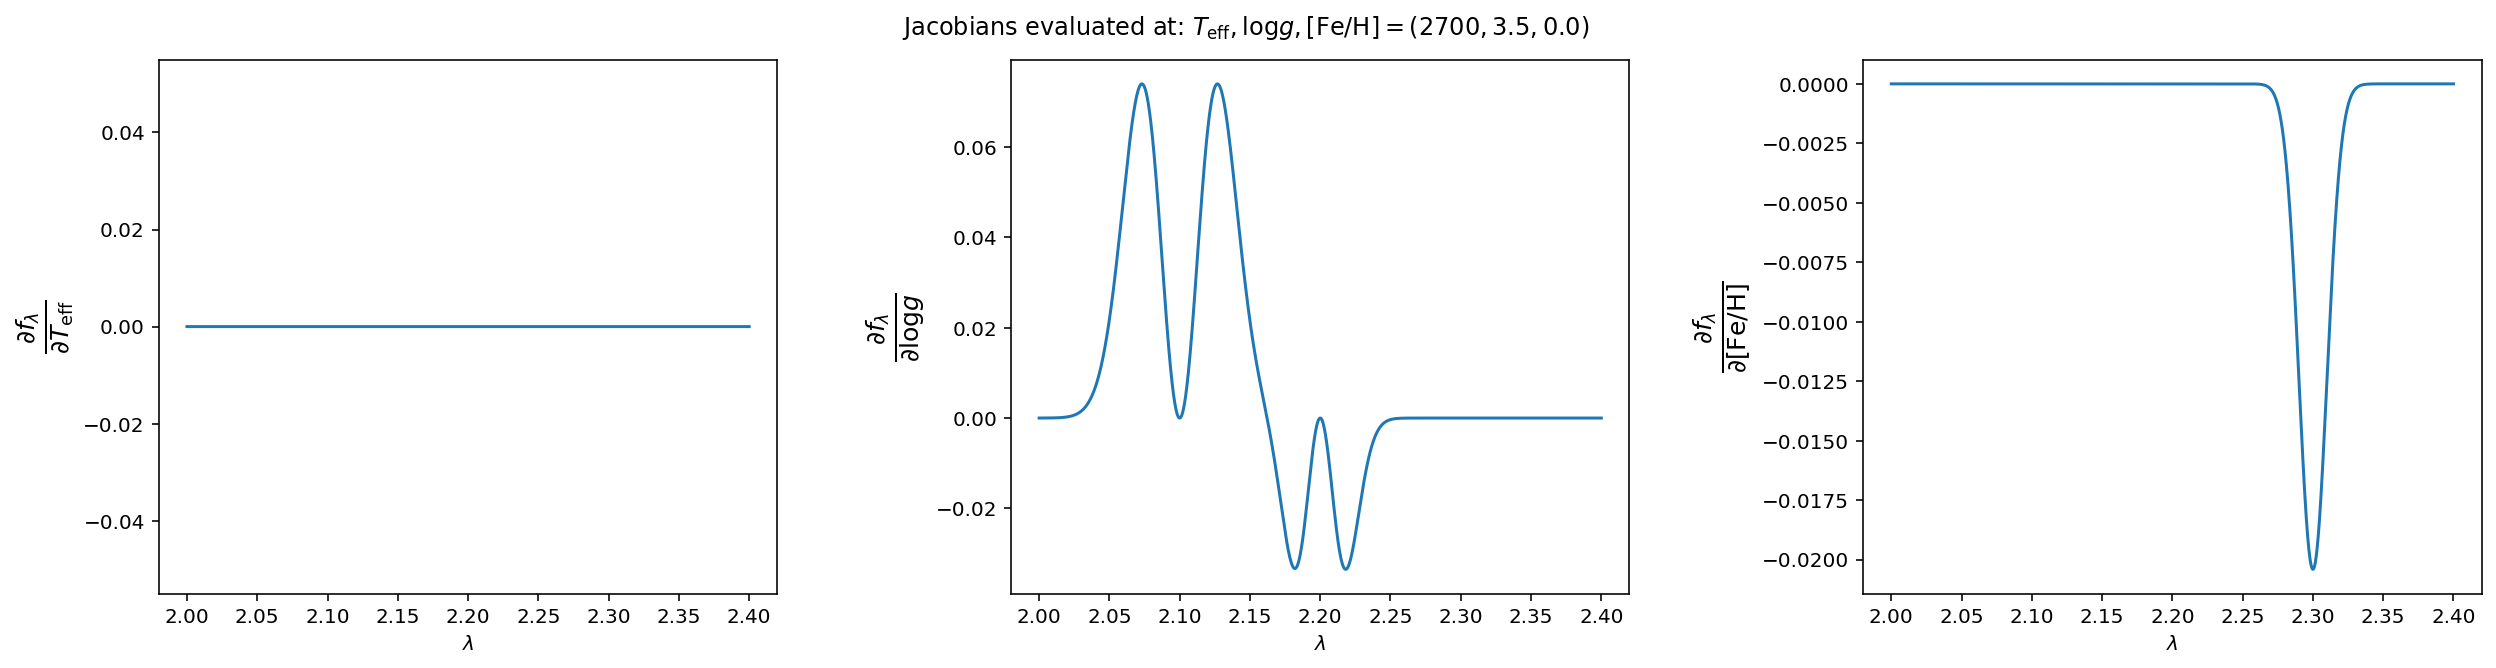

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, partial_derivative in enumerate(forward_mode_jacobian): 
    axes[i].plot(wl,partial_derivative, label = labels[i]);
    axes[i].set_xlabel('$\lambda$'); axes[i].set_ylabel(labels[i], fontsize=18) 
fig.suptitle('Jacobians evaluated at: $T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}] = (2700, 3.5, 0.0)$')
plt.tight_layout(pad=3);

Awesome!  We computed exact Jacobians instantly!  Each plot shows the partial derivative of the spectrum with respect to a stellar parameter.

In [10]:
flux = synthetic_spectrum((2700, 3.5, 0.0))

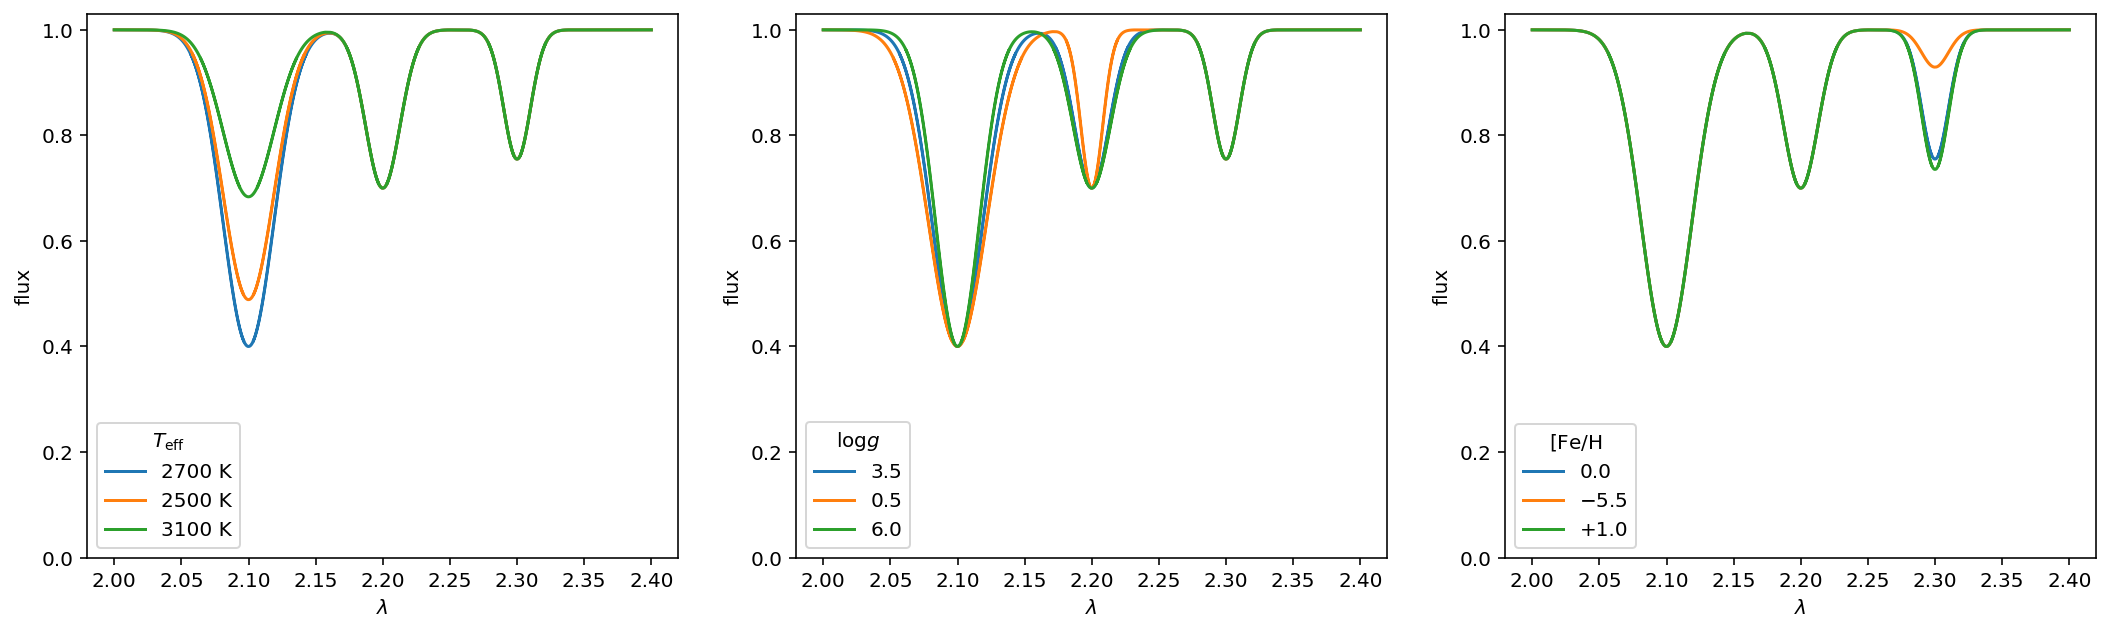

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


axes[0].step(wl, flux, label='2700 K');
axes[0].step(wl, synthetic_spectrum((2500, 3.5, 0.0)), label='2500 K')
axes[0].step(wl, synthetic_spectrum((3100, 3.5, 0.0)), label='3100 K')
axes[0].set_xlabel('$\lambda$'); axes[0].set_ylabel('flux');axes[0].legend(loc='best', title='$T_{\mathrm{eff}}$');axes[0].set_ylim(0);

axes[1].step(wl, flux, label='3.5');
axes[1].step(wl, synthetic_spectrum((2700, 0.5, 0.0)), label='0.5')
axes[1].step(wl, synthetic_spectrum((2700, 6.0, 0.0)), label='6.0')
axes[1].set_xlabel('$\lambda$'); axes[1].set_ylabel('flux');axes[1].legend(loc='best', title='$\log{g}$');axes[1].set_ylim(0);


axes[2].step(wl, flux, label='0.0');
axes[2].step(wl, synthetic_spectrum((2700, 3.5, -5.5)), label='$-5.5$')
axes[2].step(wl, synthetic_spectrum((2700, 3.5, 1.0)), label='+1.0')
axes[2].set_xlabel('$\lambda$'); axes[2].set_ylabel('flux');axes[2].legend(loc='best', title='$[\mathrm{Fe}/\mathrm{H}$');axes[2].set_ylim(0);

## How about applying Jax to real data?  Can we use gradient descent of the likelihood function?

Let's generates some *fake data*, and attempt to fit the data with MCMC.  We expect to see degeneracies.

In [12]:
import numpy as np_original

In [13]:
true_parameters = (3217.0, 4.77, -1.62)

The observation will have a coarser wavelength sampling:

In [14]:
wl = np.linspace(2.0, 2.4, 200)

In [15]:
noiseless_signal = synthetic_spectrum(true_parameters)

In [16]:
sigma = 0.01
noise = np_original.random.normal(0, sigma, size=len(noiseless_signal))

In [17]:
fake_data = noiseless_signal + noise

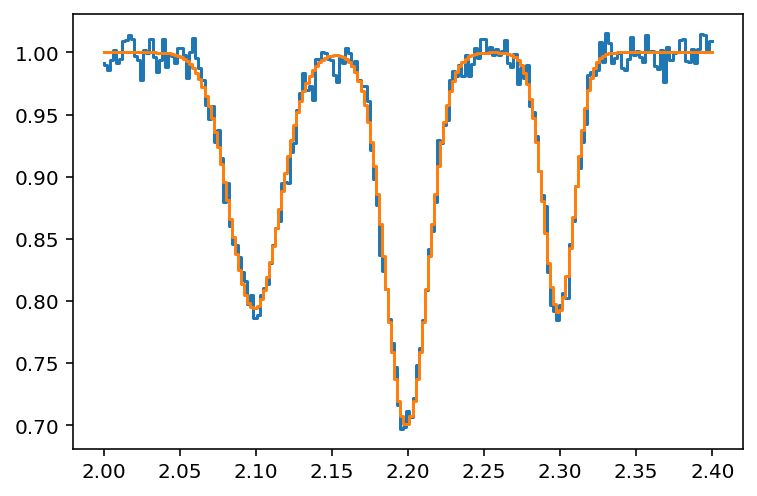

In [18]:
plt.step(wl, fake_data);
plt.step(wl, noiseless_signal);

Construct a chi square **Likelihood function**: $\mathcal{L}$.

We want to compute

$$\frac{\partial \mathcal{L}}{\partial T_{\mathrm{eff} }}, \frac{\partial \mathcal{L}}{\partial \log{g}}, \frac{\partial \mathcal{L}}{\partial [\mathrm{Fe}/\mathrm{H}]}$$

In [19]:
def log_likelihood(theta):
    model = synthetic_spectrum(theta)
    residuals = model - fake_data
    chi_square = -0.5*np.sum(residuals**2/sigma**2)
    return chi_square

In [20]:
input_vector = (3300.0, 4.5, 0.0)
input_vector = true_parameters

In [21]:
this_gradient_vector = jacrev(log_likelihood)(input_vector)

What does it look like?

In [22]:
this_gradient_vector

(DeviceArray(0.05886479, dtype=float32),
 DeviceArray(-1.0072676, dtype=float32),
 DeviceArray(6.075556, dtype=float32))

Let's get the Hessian!

In [23]:
this_Hessian_matrix = jacfwd(jacrev(log_likelihood))(input_vector)

In [24]:
import seaborn as sns

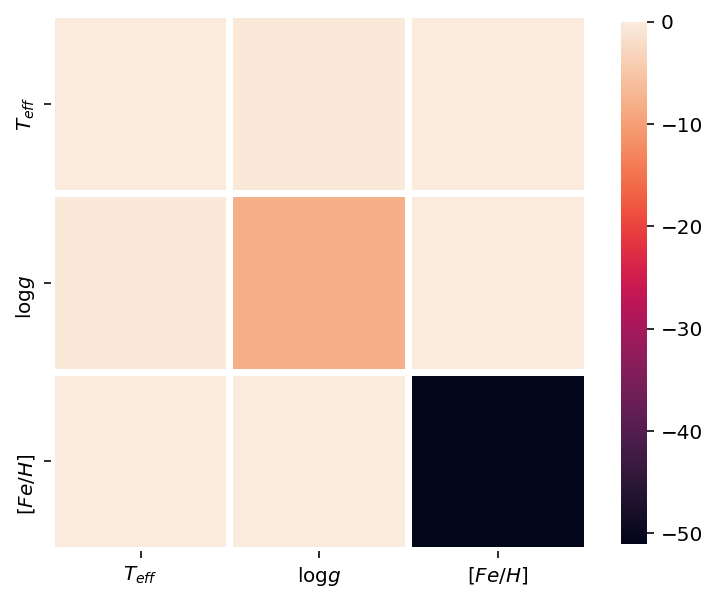

In [25]:
fig, ax = plt.subplots(figsize=(6,6))
labels=['$T_{eff}$', '$\log{g}$', '$[Fe/H]$']
sns.heatmap(this_Hessian_matrix, square=True, ax=ax, xticklabels=labels, 
            yticklabels=labels, cbar_kws={"shrink": 0.8}, linewidths=3, )

What about the inverse of this matrix?

In [26]:
matrix_Hessian_inverse = np.linalg.inv(np.array(this_Hessian_matrix))

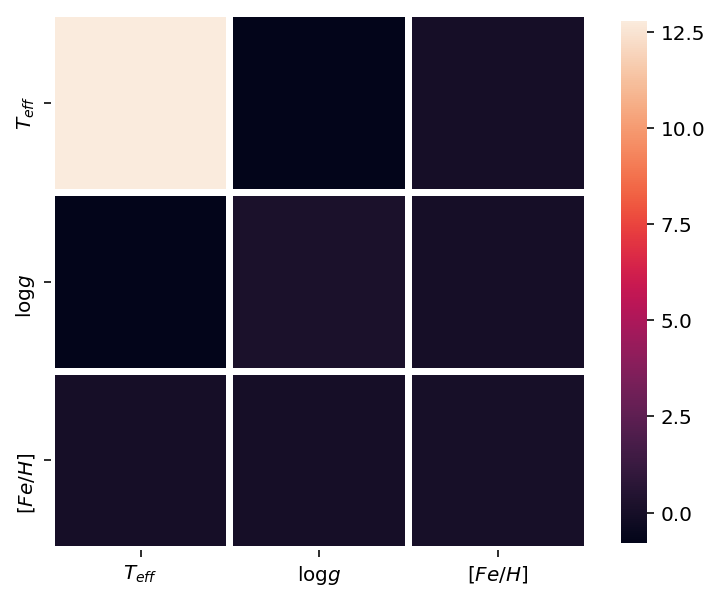

In [27]:
fig, ax = plt.subplots(figsize=(6,6))
labels=['$T_{eff}$', '$\log{g}$', '$[Fe/H]$']
sns.heatmap(-1*matrix_Hessian_inverse, square=True, ax=ax, xticklabels=labels, 
            yticklabels=labels, cbar_kws={"shrink": 0.8}, linewidths=3, )

Let's plot draws from this matrix:

In [28]:
draws = np_original.random.multivariate_normal(true_parameters, -1*matrix_Hessian_inverse, size=10000)

/Users/obsidian/anaconda3/envs/TgiF/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [29]:
teffs, loggs = draws[:, 0:2].T

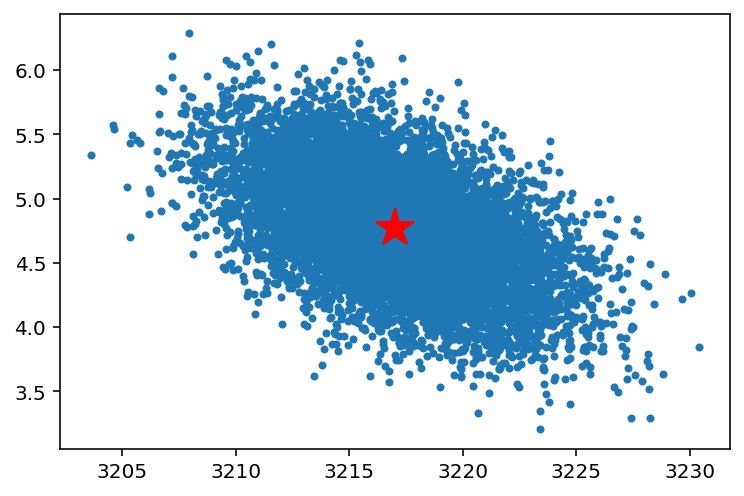

In [30]:
plt.plot(teffs, loggs, '.')
plt.plot([true_parameters[0]], [true_parameters[1]], 'r*', ms=20)

Awesome!  Let's draw likelihood contours.  We'll take the code from [this plotting example in astroML](https://github.com/astroML/astroML/blob/master/astroML/plotting/tools.py).

In [31]:
from matplotlib.patches import Ellipse

In [32]:
def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

In [33]:
mean = true_parameters[0:2]
cov = -1*matrix_Hessian_inverse[0:2, 0:2]

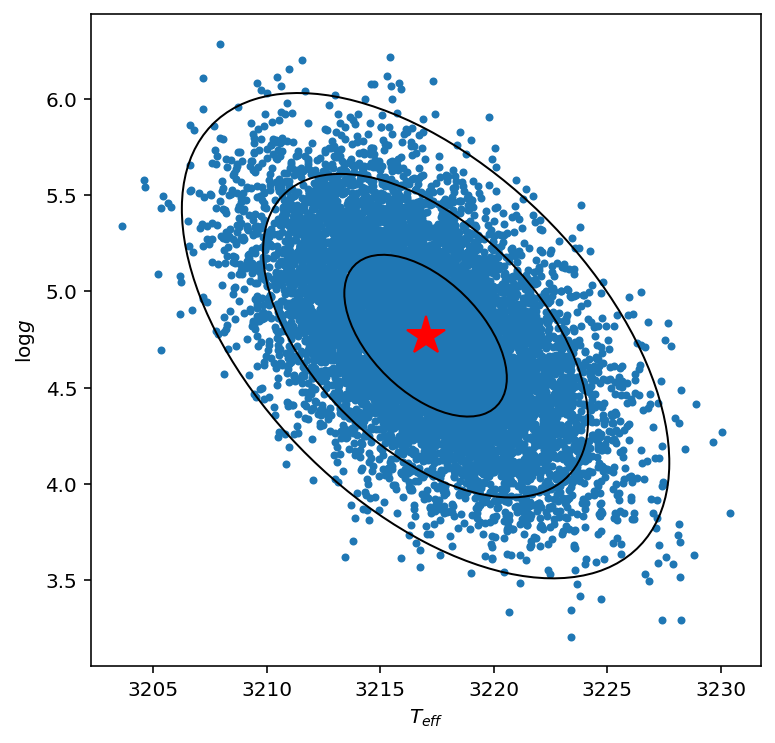

In [34]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(teffs, loggs, '.')
plt.plot([true_parameters[0]], [true_parameters[1]], 'r*', ms=20)
draw_ellipse(mean, cov, ax=ax, fc='none', ec='k', zorder=10)
plt.xlabel("$T_{eff}$")
plt.ylabel("$\log{g}$");

Awesome!! Let's compare that to a grid search over likelihood!

In [35]:
n_teffs, n_loggs = 100, 150
teff_vals = np.linspace(3200, 3250, n_teffs)
logg_vals = np.linspace(2, 7, n_loggs)
likelihood_grid = np_original.zeros((n_teffs, n_loggs)) # we don't need Jax here

In [36]:
from tqdm import tqdm

This step takes about 90 seconds:

In [37]:
for i, teff in tqdm(enumerate(teff_vals), total=n_teffs):
    for j, logg in enumerate(logg_vals):
        likelihood_grid[i,j] = log_likelihood((teff, logg, true_parameters[-1]))

100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


We will compare the True value and its Hessian-based contours to the evaluated likelihood surface.

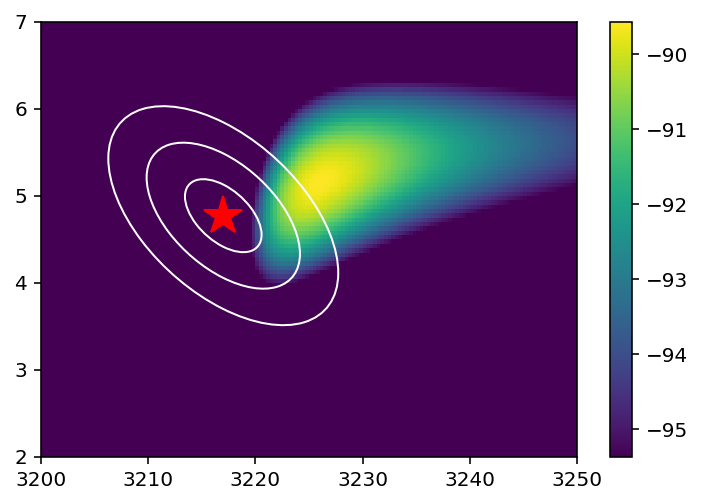

In [38]:
fig, ax = plt.subplots()
plt.plot([true_parameters[0]], [true_parameters[1]], 'r*', ms=20)
cb = ax.imshow(likelihood_grid, 
           extent=[teff_vals.min(), teff_vals.max(), logg_vals.min(), logg_vals.max()], 
           aspect='auto',
           vmin=likelihood_grid.max()-5.8, vmax=likelihood_grid.max());

draw_ellipse(mean, cov, ax=ax, fc='none', ec='w', zorder=10)

fig.colorbar(cb);

Hmmm, the Hessian-based contours do not mimick the likelihood grid-search contour.  The Hessian is a sensitive function of the likelihood surface, as we might expect.

We're also only showing two dimensions.  The True likelihood surface exists as a scalar field in 3D.  The marginalization should be immune to the third dimension.

In [39]:
true_parameters

(3217.0, 4.77, -1.62)

### Let's by-eye guess on the `MLE`.

First let's just guess where the Maximum Likelihood Estimate is located.  We will place a blue square where we think the likelihood is maximized.

In [57]:
new_mean = np.array([3225.85, 5.19])
new_Hessian_matrix = jacfwd(jacrev(log_likelihood))((*new_mean, -1.62))
new_Hessian_inverse = np.linalg.inv(np.array(new_Hessian_matrix))
new_cov = -1*new_Hessian_inverse[0:2, 0:2]

In [58]:
new_cov

DeviceArray([[ 6.9326777 ,  1.1766278 ],
             [ 1.1766279 , -0.44524103]], dtype=float32)

In [59]:
new_mean

DeviceArray([3225.85,    5.19], dtype=float32)

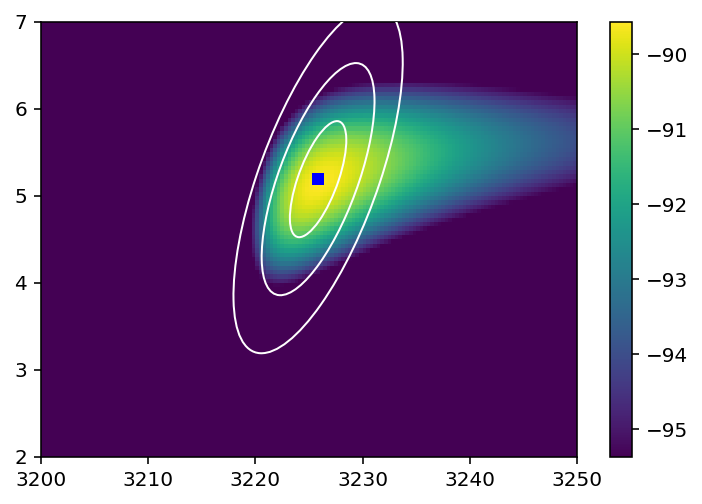

In [62]:
fig, ax = plt.subplots()
plt.plot([new_mean[0]], [new_mean[1]], 'bs', ms=5)
cb = ax.imshow(likelihood_grid, 
           extent=[teff_vals.min(), teff_vals.max(), logg_vals.min(), logg_vals.max()], 
           aspect='auto',
           vmin=likelihood_grid.max()-5.8, vmax=likelihood_grid.max());

draw_ellipse(new_mean, np.abs(new_cov), ax=ax, fc='none', ec='w', zorder=11)

fig.colorbar(cb);

In [61]:
np.sqrt(np.diag(cov)), np.sqrt(np.diag(np.abs(new_cov)))

(DeviceArray([3.577346  , 0.41962525], dtype=float32),
 DeviceArray([2.6329978 , 0.66726387], dtype=float32))

A few insights:
- The standard errors are *comparable* in the local vicinity of the MLE
- The covariance around the MLE is sometimes not positive semi-definite
- The off-diagonal covariance entries are sensitive functions of position within the MLE.

## TODO: demo gradient descent!

In [76]:
from mpl_toolkits.mplot3d import Axes3D

In [77]:
plot_6D = np.array([*input_vector, *this_gradient_vector])

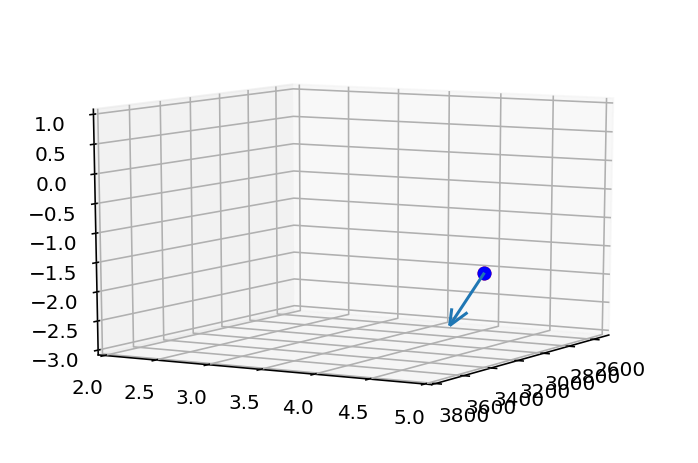

In [78]:
X, Y, Z, U, V, W = plot_6D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 30)
ax.quiver(X, Y, Z, U, V, W, normalize=True)
ax.plot(*np.array(true_parameters)[:, np.newaxis], 'ro')
ax.plot(*np.array(input_vector)[:, np.newaxis], 'bo')
ax.set_xlim([2500, 3800])
ax.set_ylim([2, 5])
ax.set_zlim([-3, +1])

plt.show()

Voila!